# TFRecord demo
In this notebook, we take a look at TFRecord 
* how to create a TFRecord from annotated images
* how to load and visualize TFRecord
Let's start by loading some modules

In [79]:
import glob
import yaml
import os
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

additional_path = '..'
if not additional_path in sys.path:
    sys.path.insert(0, additional_path)
    
from object_detection.utils import dataset_util
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils

We load the annotated data

In [16]:
data_dir = '../dataset-sdcnd-capstone/sim_training_data'
yaml_file = glob.glob(os.path.join(data_dir, '*.yaml'))[0]
label_file = '../dataset-sdcnd-capstone/label_map.pbtxt'

In [18]:
with open(yaml_file, 'rb') as f:
    annotated_samples = yaml.load(f.read())
print('Number samples {}'.format(len(annotated_file)))

label_map_dict = label_map_util.get_label_map_dict(label_file)

Number samples 277


In [19]:
label_map_dict

{'Green': 1, 'NoTrafficLight': 4, 'Red': 2, 'Yellow': 3}

In [109]:
category_index = {}
for k,v in label_map_dict.items():
    category_index[v] = {'name' : k}
    
category_index

{1: {'name': 'Green'},
 2: {'name': 'Red'},
 3: {'name': 'Yellow'},
 4: {'name': 'NoTrafficLight'}}

The `annotated_samples` is a list of annotated images, each item is a dict that contains

* `class`: the datatype
* `filename`: the location of the image
* `annotations`: a list of annotation each is a list that contain `class` i.e label and a bounding box defined by `xmin, ymin, x_width, y_width`

Let's view one sample

In [11]:
annotated_samples[0]

{'annotations': [{'class': 'Green',
   'x_width': 52.65248226950354,
   'xmin': 130.4964539007092,
   'y_height': 119.60283687943263,
   'ymin': 289.36170212765956},
  {'class': 'Green',
   'x_width': 50.156028368794296,
   'xmin': 375.60283687943263,
   'y_height': 121.87234042553195,
   'ymin': 293.90070921985813},
  {'class': 'Green',
   'x_width': 53.33333333333326,
   'xmin': 623.6595744680851,
   'y_height': 119.82978723404256,
   'ymin': 297.7588652482269}],
 'class': 'image',
 'filename': 'sim_data_capture/left0003.jpg'}

## Create the TFRecord
We learn from the following examples
* the `create_pascal_tf_record.py` in [dataset_tools](https://github.com/tensorflow/models/blob/master/research/object_detection/dataset_tools/) of the repository **Tensorflow Object Detection API**
* the `data_conversion_udacity_sim_large.py` from this [repository](https://github.com/swirlingsand/deeper-traffic-lights)

The main idea is convert each annotated sample into a `tf.train.Example`

In [44]:
def dict_to_tf_example(annotated_sample, 
                       img_h, 
                       img_w,
                       data_dir,
                       label_map_dict):
    height = img_h # Image height
    width = img_w # Image width

    filename = annotated_sample['filename'] # Filename of the image. Empty if image is not from file
    with tf.gfile.GFile(os.path.join(data_dir, filename), 'rb') as fid:
        encoded_image = fid.read()

    image_format = 'jpg'.encode() 

    xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
    xmaxs = [] # List of normalized right x coordinates in bounding box
                # (1 per box)
    ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
    ymaxs = [] # List of normalized bottom y coordinates in bounding box
                # (1 per box)
    classes_text = [] # List of string class name of bounding box (1 per box)
    classes = [] # List of integer class id of bounding box (1 per box)

    for box in annotated_sample['annotations']:
        #if box['occluded'] is False:
        #print("adding box")
        xmins.append(float(box['xmin'] / width))
        xmaxs.append(float((box['xmin'] + box['x_width']) / width))
        ymins.append(float(box['ymin'] / height))
        ymaxs.append(float((box['ymin']+ box['y_height']) / height))
        classes_text.append(box['class'].encode())
        classes.append(int(label_map_dict[box['class']]))

    # convert to string
    filename = filename.encode('utf-8')
    
    # create tf.train.Example
    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_image),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

In [60]:
def create_tf_record(annotated_samples, img_h, img_w, data_dir, label_map_dict, out_file):
    writer = tf.python_io.TFRecordWriter(out_file)
    nb_samples = len(annotated_samples)
    for i, annotated_sample in enumerate(annotated_samples):
        tf_example = dict_to_tf_example(annotated_sample, 
                                        img_h, 
                                        img_w,
                                        data_dir, 
                                        label_map_dict)
        writer.write(tf_example.SerializeToString())
        
        if i % 10 == 0:
            sys.stdout.write('\rPercent done {:.2f}%'.format((i/nb_samples)*100))
    
    writer.close()
    print('\nDone, TFRecord is saved to {}'.format(out_file))

In [61]:
SIM_IMG_H = 600
SIM_IMG_W = 800
out_file  = '../dataset-sdcnd-capstone/sim.record'
create_tf_record(annotated_samples, 
                 SIM_IMG_H, SIM_IMG_W, 
                 data_dir=data_dir, 
                 label_map_dict=label_map_dict,
                 out_file = out_file)

Percent done 97.47%
Done, TFRecord is saved to ../dataset-sdcnd-capstone/sim.record


## Load and visualize TFRecord
Now we have created TFRecord, we look at how to load it and visualize it

SparseTensorValue(indices=array([[0],
       [1],
       [2]]), values=array([1, 1, 1]), dense_shape=array([3]))
SparseTensorValue(indices=array([[0],
       [1],
       [2]]), values=array([3, 3, 3]), dense_shape=array([3]))


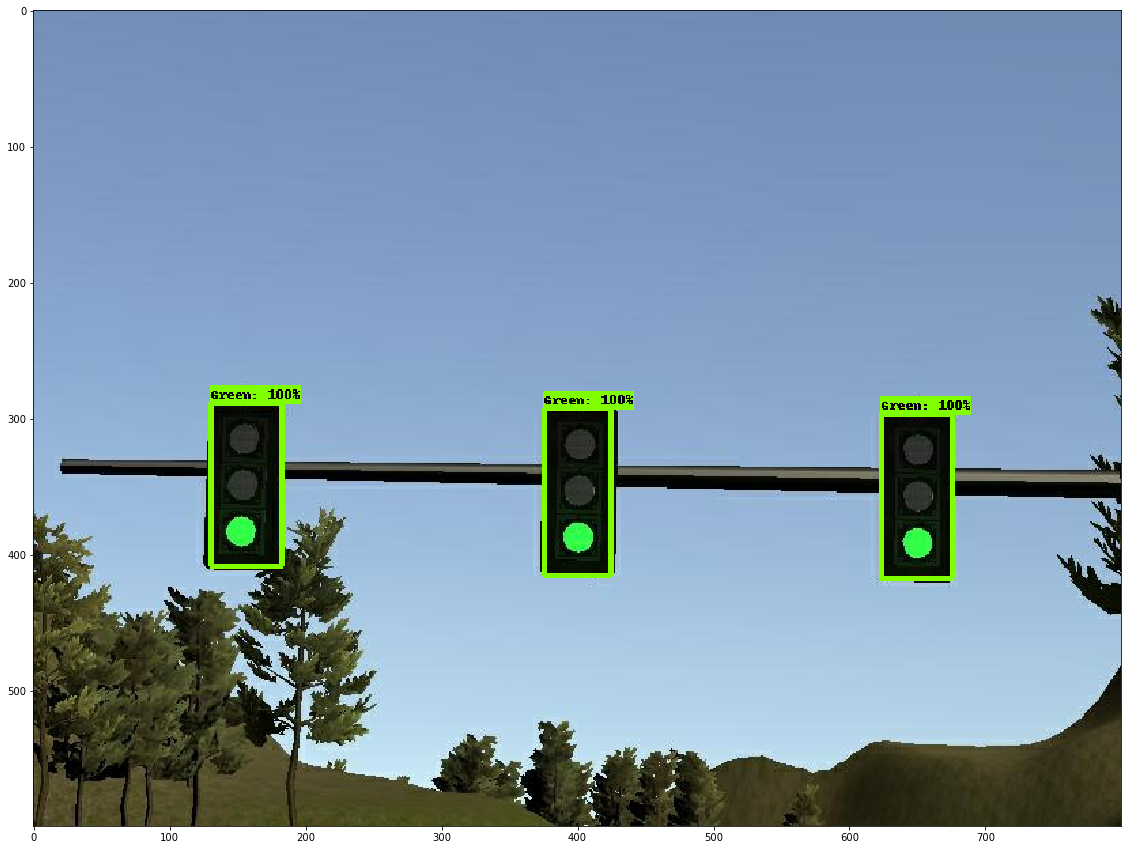

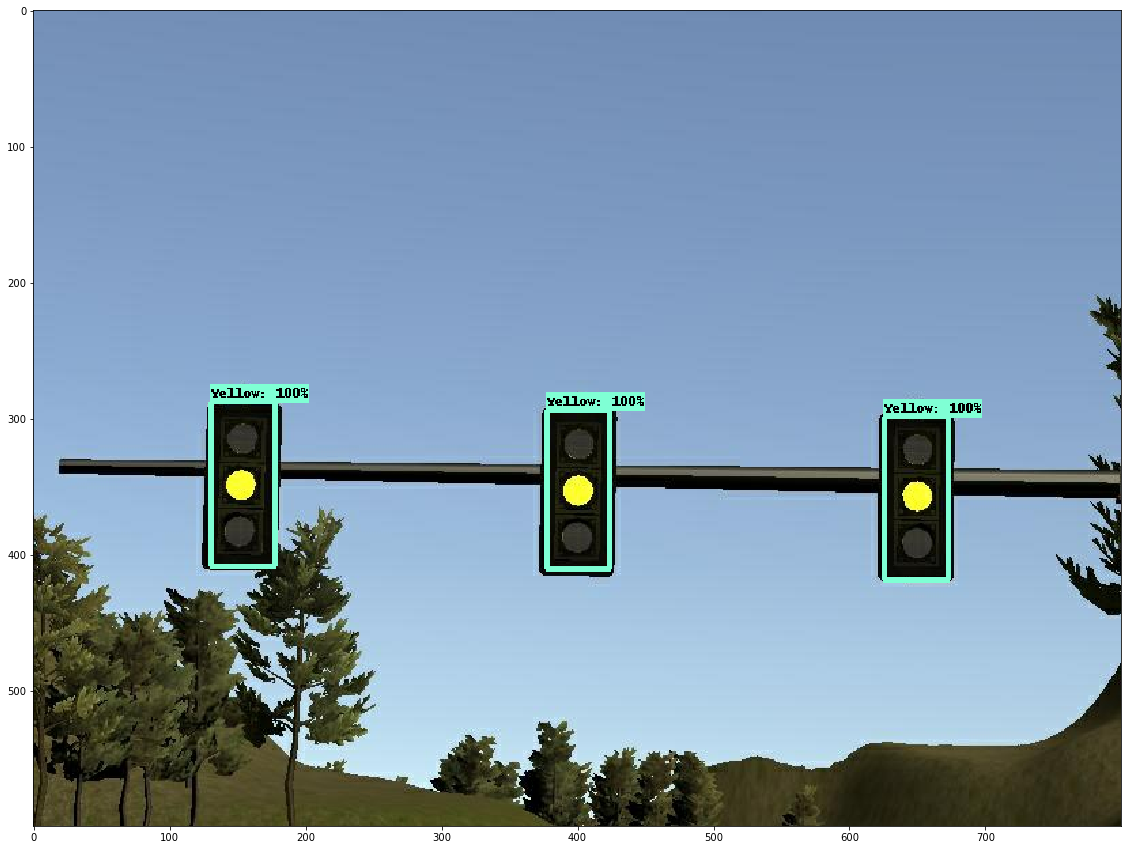

In [111]:
with tf.Session() as sess:
    features_map = {'image/height': tf.FixedLenFeature([], tf.int64),
                    'image/width': tf.FixedLenFeature([], tf.int64),
                    'image/filename': tf.FixedLenFeature([], tf.string),
                    'image/source_id': tf.FixedLenFeature([], tf.string),
                    'image/encoded': tf.FixedLenFeature([], tf.string),
                    'image/format': tf.FixedLenFeature([], tf.string),
                    'image/object/bbox/xmin': tf.VarLenFeature(dtype=tf.float32),
                    'image/object/bbox/xmax': tf.VarLenFeature(dtype=tf.float32),
                    'image/object/bbox/ymin': tf.VarLenFeature(dtype=tf.float32),
                    'image/object/bbox/ymax': tf.VarLenFeature(dtype=tf.float32),
                    'image/object/class/text': tf.VarLenFeature(dtype=tf.string),
                    'image/object/class/label': tf.VarLenFeature(dtype=tf.int64)
                    }
    
    
    filename_queue = tf.train.string_input_producer([out_file], num_epochs=1)
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features=features_map)
    
    image = tf.image.decode_jpeg(features['image/encoded'], channels=3)
    img_h = features['image/height']
    img_w = features['image/width']
    bbox_xmin = features['image/object/bbox/xmin']
    bbox_ymin = features['image/object/bbox/ymin']
    bbox_xmax = features['image/object/bbox/xmax']
    bbox_ymax = features['image/object/bbox/ymax']
    label = features['image/object/class/label']
    
    # Initialize all global and local variables
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
    # Create a coordinator and run all QueueRunner objects
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    imgs = []
    for batch_index in range(2):
        img, h, w, xmins, ymins, xmaxs, ymaxs, classes  = sess.run([image, img_h, img_w,
                                                                  bbox_xmin, bbox_ymin,
                                                                  bbox_xmax, bbox_ymax,
                                                                  label])
        boxes = np.array([[ymin * h, xmin * w, ymax * h, xmax * w] for ymin,xmin,ymax, xmax in zip(ymins.values, 
                                                                                   xmins.values, 
                                                                                   ymaxs.values, 
                                                                                   xmaxs.values)])
        scores = [1] * len(boxes)
        
        img_bb = visualization_utils.visualize_boxes_and_labels_on_image_array(img,
                                                                              boxes,
                                                                              classes.values,
                                                                              scores,
                                                                              category_index)
        
        fig = plt.figure(figsize = (20,15))
        plt.imshow(img_bb)

So we have learnt how to load TFRecord, look at above code we notice that:
* for `tf.VarLenFeature`, the return is of type `SparseTensorValue` which contains both `indices` and `values`, and we only need `values` field.
* the map between serialized and deserialized is
    * int64_feature <-> tf.int64
    * bytes_feature <-> tf.string
    * float <-> tf.float32
    * list of un-specified length <-> tf.VarLenFeature